<a href="https://colab.research.google.com/github/annulet/CNN_NVIDIA/blob/master/segmentation_coco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Обучить модель семантической сегментации (человек-vs-фон) на подмножестве датасета MS COCO
Библиотеки: [Python, Tensorflow]

In [0]:
# Подключение к Google drive

# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
%tensorflow_version 2.x

import os

import tensorflow as tf
import tensorflow_datasets as tfds
import skimage.io as io
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import json
from tqdm import tqdm_notebook

Загрузка сырых данных

In [3]:
if 1:
  !mkdir -p data

  !cd data && wget http://images.cocodataset.org/zips/train2017.zip
  !cd data && wget http://images.cocodataset.org/zips/val2017.zip

  !cd data && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

  !cd data && unzip -q train2017.zip
  !cd data && unzip -q val2017.zip
  !cd data && unzip -q annotations_trainval2017.zip

  !cd data && git clone https://github.com/cocodataset/cocoapi
  !cd data/cocoapi/PythonAPI && make

--2020-04-21 07:26:20--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.142.44
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.142.44|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  35.3MB/s    in 8m 50s  

2020-04-21 07:35:10 (34.8 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2020-04-21 07:35:12--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.84.0
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.84.0|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  35.5MB/s    in 23s     

2020-04-21 07:35:35 (34.4 MB/s) - ‘val20

In [4]:
import os
len(os.listdir('/content/data/train2017'))

118287

Подготовка COCO API

In [0]:
COCO_ROOT = './data'
import sys
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO

Универсальный класс Dataset для сегментации

In [0]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0]
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))

        else: # Central crop
            shape = tf.shape(img)
            h0 = (shape[0] - inp_size) // 2
            w0 = (shape[1] - inp_size) // 2
            img = img[h0: h0 + inp_size, w0: w0 + inp_size, :]

        return img


    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[..., :3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[..., 3:4], tf.float32)

            return img, mask_class


        dataset = tf.data.Dataset.from_tensor_slices(self.img_list[:5000])
        dataset = dataset.shuffle(buffer_size=len(self.img_list[:5000]))
        dataset = dataset.map(item_to_images)
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset


    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,: 3], tf.float32 ) / np.float32(255.)
            mask_class = tf.cast(img_combined[..., 3:4], tf.float32)
            
            return img, mask_class

        
        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

Класс для сегментационного датасета COCO

In [0]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)


    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])
        
        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)
        
        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)
            
        return img_combined

In [8]:
COCO_dataset_train = COCO_Dataset('train')

loading annotations into memory...
Done (t=15.82s)
creating index...
index created!


In [9]:
COCO_dataset_test = COCO_Dataset('val')

loading annotations into memory...
Done (t=2.13s)
creating index...
index created!


Формирование тренировочного датасета

In [0]:
INP_SIZE = 256
NUM_EPOCHS = 1
BATCH_SIZE = 32

In [0]:
train_ds = COCO_dataset_train.train_dataset(batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, inp_size=INP_SIZE)

In [12]:
train_ds

<BatchDataset shapes: ((32, 256, 256, None), (32, 256, 256, None)), types: (tf.float32, tf.float32)>

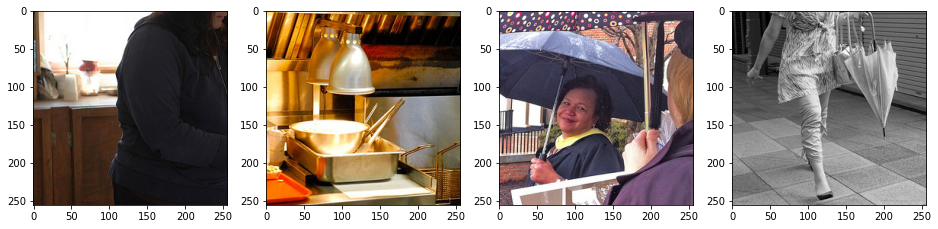

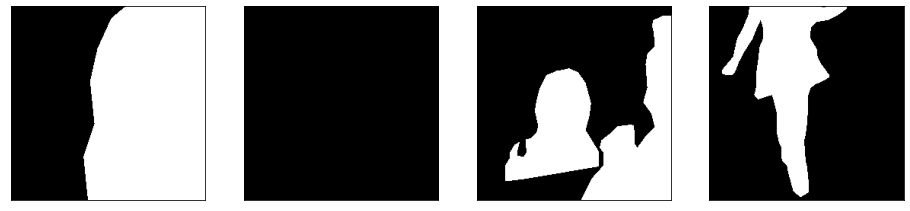

In [13]:
some_samples = [x for x in iter(train_ds.take(4))]

fig = plt.figure(figsize=(16, 16))
for i in range(len(some_samples)):
    ax1 = fig.add_subplot(1, 4, i+1)
    # print(some_samples[i][0].shape)
    # print(some_samples[i][1].shape)
    ax1.imshow(some_samples[i][0][0])

fig = plt.figure(figsize=(16, 16))
for i in range(len(some_samples)):
    ax2 = fig.add_subplot(1, 4, i+1)
    ax2.imshow(some_samples[i][1][0].numpy().reshape(256, 256), cmap='gray')
    plt.xticks([]), plt.yticks([])
plt.show()

Заглянем во внутрь

Формирование валидационного датасета

In [0]:
test_ds = COCO_dataset_test.val_dataset(batch_size=BATCH_SIZE, inp_size=INP_SIZE)

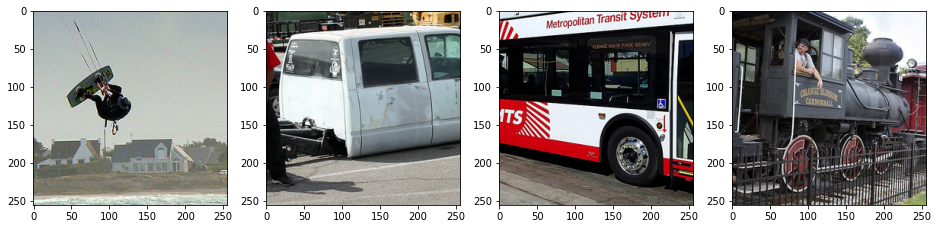

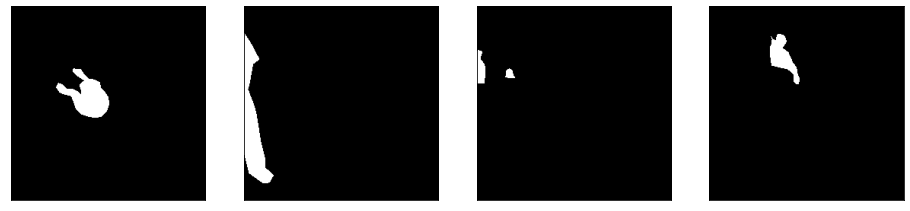

In [15]:
some_samples = [x for x in iter(test_ds.take(4))]

fig = plt.figure(figsize=(16, 16))
for i in range(len(some_samples)):
    ax1 = fig.add_subplot(1, 4, i+1)
    ax1.imshow(some_samples[i][0][0])

fig = plt.figure(figsize=(16, 16))
for i in range(len(some_samples)):
    ax2 = fig.add_subplot(1, 4, i+1)
    ax2.imshow(some_samples[i][1][0].numpy().reshape(256, 256), cmap='gray')
    plt.xticks([]), plt.yticks([])
plt.show()

Создание модели U-net

In [0]:
# U-Net
def build_model():
    x = tf.keras.layers.Input((256, 256, 3))
    
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    out1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out1)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out2)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out4 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out4)

    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out4, out], axis=3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out3, out], axis=3)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out2, out], axis=3)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out1, out], axis=3)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(out)

    return tf.keras.Model(inputs=x, outputs=out)

In [0]:
model = build_model()

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

Визуализация U-net

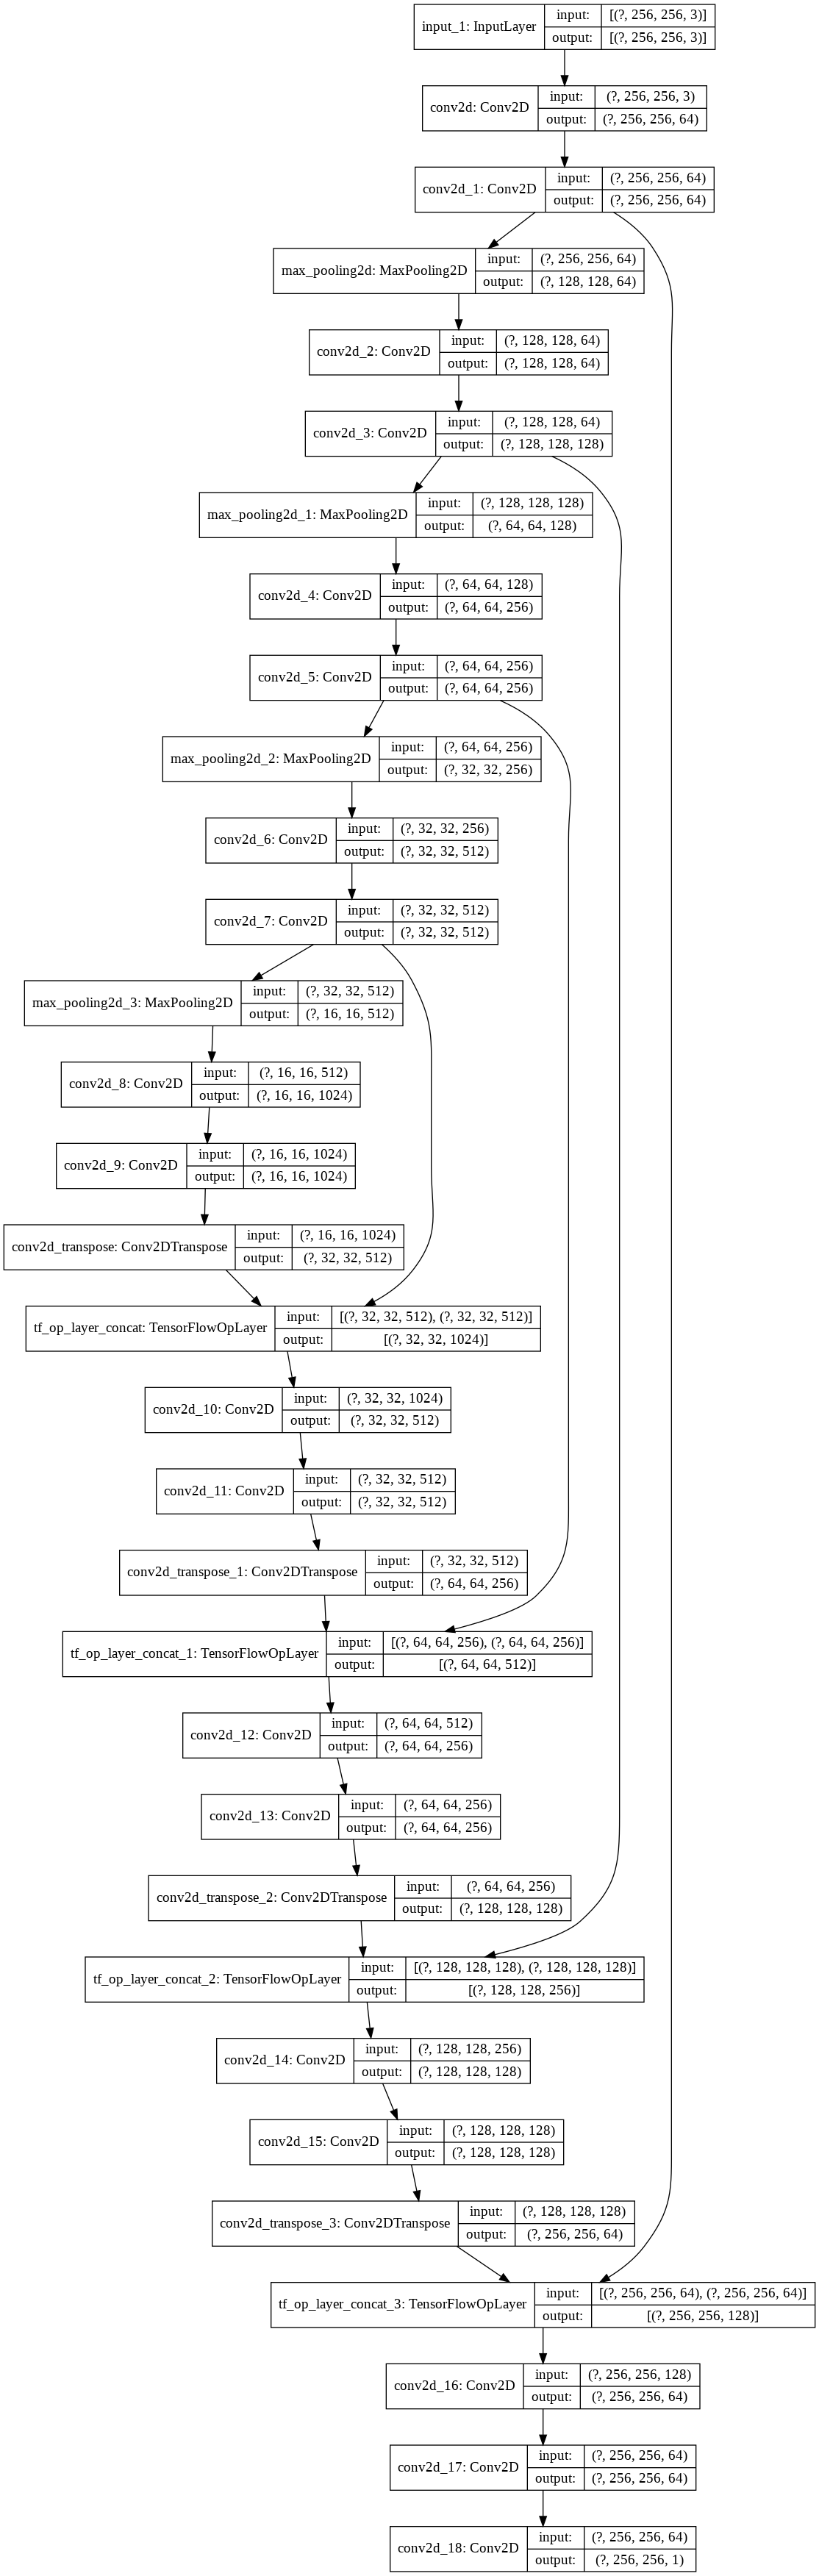

In [19]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [0]:
LEARNING_RATE = 0.0001

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
# optimizer = tf.keras.optimizers.RMSprop(LEARNING_RATE)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy'])

Обучаем сеть

In [21]:
%%time

history = model.fit(
    train_ds,
    epoch=1
)

156/156 [==============================] - 12060s 77s/step - loss: 0.5201 - accuracy: 0.7768
CPU times: user 12h 35min 5s, sys: 5min 42s, total: 12h 40min 47s
Wall time: 3h 22min 22s


In [22]:
model.evaluate(test_ds)

84/84 [==============================] - 1658s 20s/step - loss: 0.5235 - accuracy: 0.7433


[0.5235342979431152, 0.7432888150215149]

In [0]:
prediction = model.predict(test_ds)

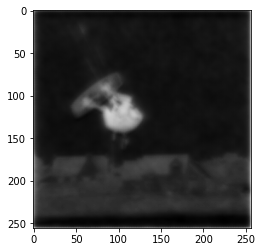

In [34]:
plt.imshow(prediction[0].reshape(256, 256), cmap='gray')
plt.show()